In [1]:
import os
from tensorflow import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import tensorflow as tf
from keras.applications import ResNet50

In [2]:
# on Google Colab, get the dataset from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# unzip the dataset for use
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/Poison Plant Classifier/Dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import splitfolders

splitfolders.ratio("Dataset", # The location of dataset
                   output="Training_Datasets", # The output location
                   seed=42, # The number of seed
                   ratio=(.8, .2), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

Copying files: 10610 files [00:04, 2311.41 files/s]


In [32]:
train_dir = os.path.join('/content/Training_Datasets', 'train')
validation_dir = os.path.join('/content/Training_Datasets', 'val')

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'sparse', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( validation_dir, batch_size = 20, class_mode = 'sparse', target_size = (224, 224))

Found 8486 images belonging to 4 classes.
Found 2124 images belonging to 4 classes.


In [33]:
base_model = keras.Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(4, activation='softmax'))

base_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [34]:
num_epochs = 50
resnet_history = base_model.fit(train_generator, validation_data = validation_generator, epochs = num_epochs)

Epoch 1/50
425/425 [==============================] - 166s 378ms/step - loss: 3.4360 - accuracy: 0.4311 - val_loss: 6.9830 - val_accuracy: 0.2538
Epoch 2/50
425/425 [==============================] - 158s 371ms/step - loss: 2.3377 - accuracy: 0.5434 - val_loss: 2.6939 - val_accuracy: 0.4195
Epoch 3/50
425/425 [==============================] - 156s 367ms/step - loss: 2.0367 - accuracy: 0.5746 - val_loss: 1.9032 - val_accuracy: 0.6163
Epoch 4/50
425/425 [==============================] - 157s 368ms/step - loss: 1.7978 - accuracy: 0.5944 - val_loss: 1.6210 - val_accuracy: 0.6314
Epoch 5/50
425/425 [==============================] - 155s 364ms/step - loss: 1.5206 - accuracy: 0.6056 - val_loss: 1.3147 - val_accuracy: 0.6544
Epoch 6/50
425/425 [==============================] - 157s 370ms/step - loss: 1.3463 - accuracy: 0.6128 - val_loss: 1.3716 - val_accuracy: 0.6412
Epoch 7/50
425/425 [==============================] - 156s 367ms/step - loss: 1.2136 - accuracy: 0.6334 - val_loss: 1.1036 -

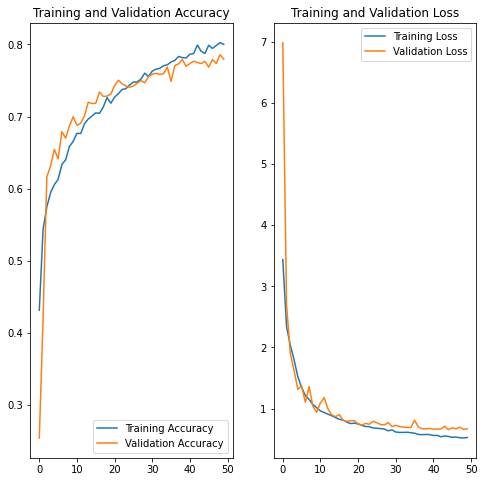

In [35]:
import matplotlib.pyplot as plt

acc = resnet_history.history['accuracy']
val_acc = resnet_history.history['val_accuracy']

loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()